In [158]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color

# Question 1 : Gabor Filters (30 points
The goal of this problem is to implement Gabor Filters and understand them, on the image
stadium.jpg. You cannot use the imgaborfilt() function directly. Helpful functions: np.roll,
np.repeat, imread, rgb2gray, abs, real.

a) (5 points) Read in the stadium.jpg file, convert it to grayscale. Display the image with
appropriate labels.

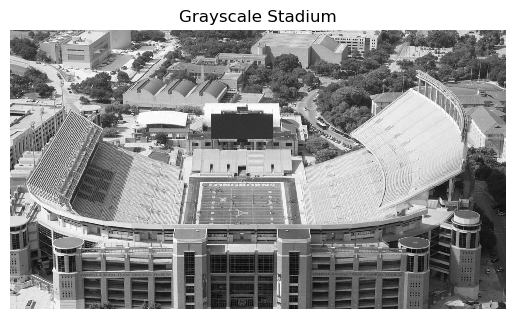

In [159]:
stadium = mpimg.imread('images/q1_stadium.jpg')
g_stadium = color.rgb2gray(stadium)

imgplot = plt.imshow(g_stadium, cmap='gray')
plt.title('Grayscale Stadium')
plt.axis('off')
plt.show()

b) (10 points) Write a function “gaborfilt()” which computes the magnitude and phase
response of a Gabor filter for the given input grayscale image. The input parameters to
this function should be the frequency in ‘cycles per image’ of the sinusoidal carrier, and
the orientation of the filter in degrees.

In [199]:
def gaborfilt(img, frequency, orientation):
    wavelength = math.sqrt(img.shape[0] ** 2 + img.shape[1] ** 2) / frequency
    sigma = 0.5 * wavelength
    gamma = 0.5
    shape = 1 + 2 * math.ceil(4 * sigma)
    gabor_filter_real = cv2.getGaborKernel((shape, shape), sigma, orientation, wavelength, gamma, psi=0)
    gabor_filter_imag = cv2.getGaborKernel((shape, shape), sigma, orientation, wavelength, gamma, psi=math.pi/2)
    gabor = cv2.filter2D(src=img, ddepth=-1, kernel=gabor_filter_real) + 1j * cv2.filter2D(src=img, ddepth=-1, kernel=gabor_filter_imag)
    mag = np.abs(gabor)
    phase = np.angle(gabor)
    return mag, phase

c) (5 points) Write a function “gaborfilt_2()” which computes the real and imaginary parts of
a Gabor filter for the given input grayscale image. The input parameters to this function
should be the frequency in ‘cycles per image’ of the sinusoidal carrier, and the
orientation of the filter in degrees.

In [200]:
def gaborfilt_2(img, frequency, orientation):
    mag, phase = gaborfilt(img, frequency, orientation)
    real = mag * np.cos(phase)
    imag = mag * np.sin(phase)
    return real, imag

d) (5 points) You should now use either of the filters from b) or c) on the grayscale version
of stadium.jpg, for different values of “frequency” and “orientation”. By changing the
orientation angle, we can search for features in a particular direction. For a frequency of
your choice, generate 10 images with orientation varying from 18 degrees to 180
degrees (in strides of 18 degrees). Display all the 10 images in a 5x2 grid with
appropriate labels. Comment on which filter you chose, from part b) or c), and why.

**Answer:** I chose the second filter and took the real component since this combines aspects of both the magnitude and the phase, which I think is useful to visualize (note: using the imaginary component would have yielded a similar result since its just sin instead of cos, meaning its just shifted)

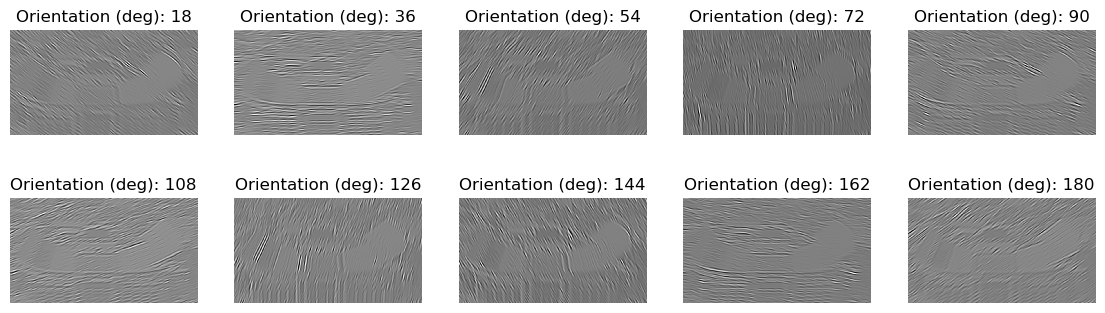

In [219]:
fig = plt.figure(figsize=(14, 4))
ax = []
for i in range(10):
    ax.append(fig.add_subplot(2,5,i+1))
    ax[i].axis('off')
    frequency = 100
    orientaiton = 18 * (i + 1)
    ax[i].title.set_text('Orientation (deg): ' + str(orientaiton))
    real, imag = gaborfilt_2(g_stadium, frequency, orientaiton)
    ax[i].imshow(real, cmap='gray')
plt.show()

e) (5 points) Comment on why you chose that particular frequency for part d), and also on
the observations on the differences between the 10 images. What direction do you think
most features are present in stadium.jpg from the images, and does that make sense?
Attach any one .jpg picture in which Gabor Filter will show up features significantly in one
orientation, but not much in all other orientations. Also mention the angle (orientation) for
the image you attach in which most features show up significantly.

**Answer:** I chose a frequency of 100 after testing out a number of different values, and 100 seemed to have the features best defined (it makes sense that it is relatively high since the input image is quite detailed and using a low frequency would cause a lot of detail to be missed out on). In the different images we see that using different orientations of the gabor filter results in the structures in the image being more or less clear (as the major edges are mostly a long a certain orientation). The best orientation in my opinion was the 180 degrees image, where the stadium and even the front of the building could be made out quite well. This makes sense since the main object in the image (the stadium) is largely defined vertically, so a gabor filter oriented at 180 degrees would be able to capture the defining structure.3

In the following image we use the gabor filter on the fence. We note that the orientation of 72 degrees seems to have the features defined most significantly which makes sense since the fence lines are slanted vertically spanning across the width of the image.

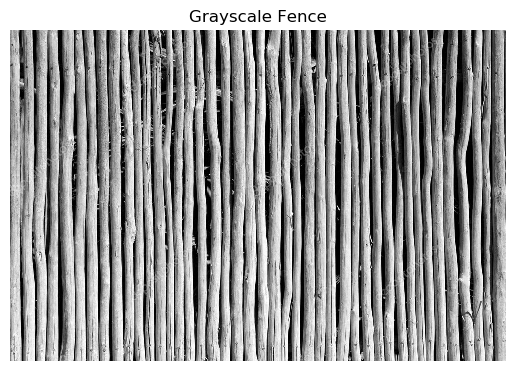

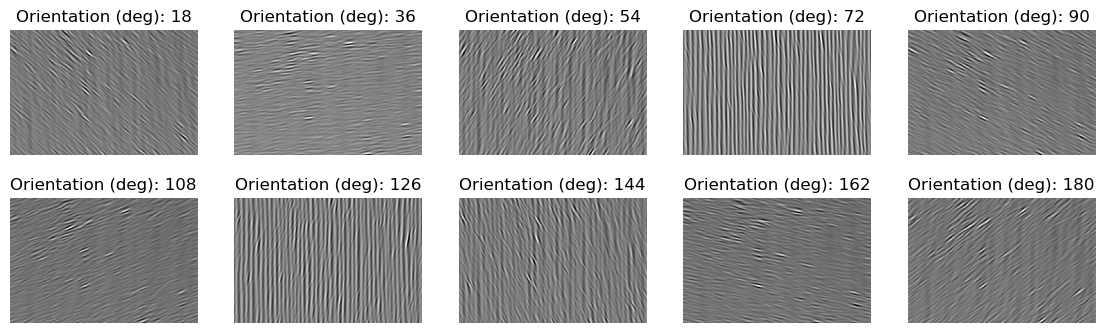

In [230]:
fence = mpimg.imread('images/q1_fence.jpg')
g_fence = color.rgb2gray(fence)

imgplot = plt.imshow(g_fence, cmap='gray')
plt.title('Grayscale Fence')
plt.axis('off')
plt.show()

fig = plt.figure(figsize=(14, 4))
ax = []
for i in range(10):
    ax.append(fig.add_subplot(2,5,i+1))
    ax[i].axis('off')
    frequency = 70
    orientaiton = 18 * (i + 1)
    ax[i].title.set_text('Orientation (deg): ' + str(orientaiton))
    real, imag = gaborfilt_2(g_fence, frequency, orientaiton)
    ax[i].imshow(real, cmap='gray')
plt.show()

# Question 2 : Non Local (NL) Means (40 points)
Here we will be looking at the application of Non-Local Means in removing noise from the
Google Chrome logo “logo.jpg” image, which is noise distorted. Helpful functions:
skimage.util.view_as_windows, scipy.spatial.distance.cdist, padarray, im2col, pdist2, sum,
reshape.

a) (5 points) You need to read logo.jpg, convert it to grayscale, and resize the image so that
it is a perfect square. Display this resulting image.

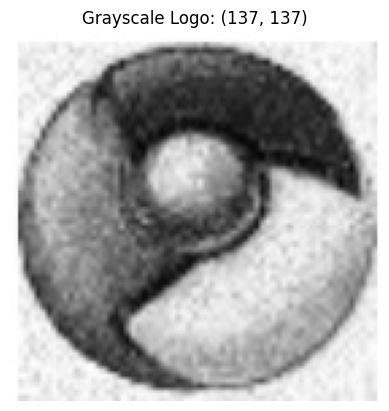

In [28]:
logo = mpimg.imread('images/q2_logo.jpg')
g_logo = color.rgb2gray(logo)
size = max(g_logo.shape)
g_logo = cv2.resize(g_logo, (size, size))

imgplot = plt.imshow(g_logo, cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Logo: ' + str(g_logo.shape))
plt.axis('off')
plt.show()

b) (10 points) You will now calculate the Luminance Similarity Measure “W(m,i)” between all
the 3x3 square windows in the image, using the information given in Module 5 slide 14
onwards. Use Kw = 1 and 𝜎w = 1. Normalize “W(m,i)” so that the sum across each row is
equal to 1.0.

In [8]:
# Finds the luminance similarity between two input WINDOWS
def similarity(Kw, sigmaw, M, I):
    return Kw * np.exp(-np.sum(np.square(I - M)) / (sigmaw ** 2))

window_size = 3
padding = window_size // 2
padded = np.pad(array=g_logo, pad_width=padding, mode='constant')
windows = np.lib.stride_tricks.sliding_window_view(padded, (window_size, window_size))
windows = windows.reshape((windows.shape[0] * windows.shape[1], windows.shape[2], windows.shape[3]))
W = np.zeros((windows.shape[0], windows.shape[0]))
for m in range(W.shape[0]):
    for i in range(W.shape[1]):
        W[m, i] = similarity(Kw=1, sigmaw=1, M=windows[m], I=windows[i])
        
for m in range(W.shape[0]):
    sum = np.sum(W[m])
    if sum == 0:
        W[m, :] = 1 / W.shape[1]
    else:
        W[m, :] /= sum

c) (5 points) From all the windows, we will now compare the similarity measure images
generated between choosing two different windows in the image. For this part, take the
3x3 window in the top-left corner of the image, and reshape it to a 3x3 matrix. Take the
first row in W which corresponds to all of the pair-wise distances to that 3x3 window, and
reshape it to the size of the original image “logo.jpg”. Display the resulting window and
the original image side by side with appropriate labels.

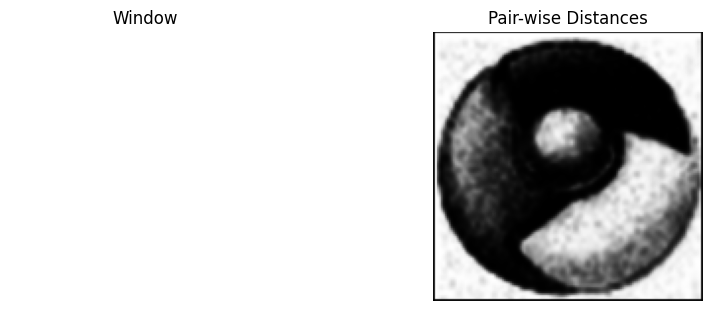

In [39]:
window = windows[g_logo.shape[0] + 1]
similarities = W[g_logo.shape[0] + 1].reshape(g_logo.shape)

fig = plt.figure(figsize=(10, 3.5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.axis('off')
ax2.axis('off')
ax1.title.set_text('Window')
ax2.title.set_text('Pair-wise Distances')
ax1.imshow(window, cmap='gray', vmin=0, vmax=1)
ax2.imshow(similarities, cmap='gray')
plt.show()

d) (5 points) You will now need to repeat the same operation you did in part c), but by
taking the 3x3 window in the middle of the left side of the image. Display the resulting
window and the original image side by side with appropriate labels.

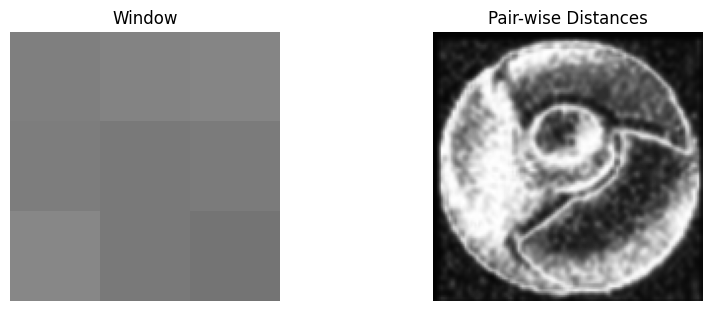

In [37]:
window = windows[(g_logo.shape[0] // 2) * g_logo.shape[0] + (g_logo.shape[1] // 4)]
similarities = W[(g_logo.shape[0] // 2) * g_logo.shape[0] + (g_logo.shape[1] // 4)].reshape(g_logo.shape)

fig = plt.figure(figsize=(10, 3.5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.axis('off')
ax2.axis('off')
ax1.title.set_text('Window')
ax2.title.set_text('Pair-wise Distances')
ax1.imshow(window, cmap='gray', vmin=0, vmax=1)
ax2.imshow(similarities, cmap='gray')
plt.show()

e) (5 points) We now have two resulting similarity measure images. What do the high and
low values correspond to in the resulting similarity measure images? Why and where do
the similarity measure images differ in part c) and d)?

**Answer:** The high (bright) pixel values correspond to a high level of luminance similarity between the extracted window and the window centered at the pixel. Similarly, the low (dark) values correspond to a low level of luminance similarity between them. We see in part c) that the extracted window is almost fully white and that is why it is very similar to other windows that would contain mostly white pixels. In part d we see that the window mostly contains grayish pixels which is reflected in the similarity output.

f) (10 points) Using the luminance similarity measure, perform Non Local (NL) Means
filtering on logo.jpg, and remove the noise. Display the resulting image and the original
image in a 2x1 grid with appropriate results. Comment a few lines on the result achieved.

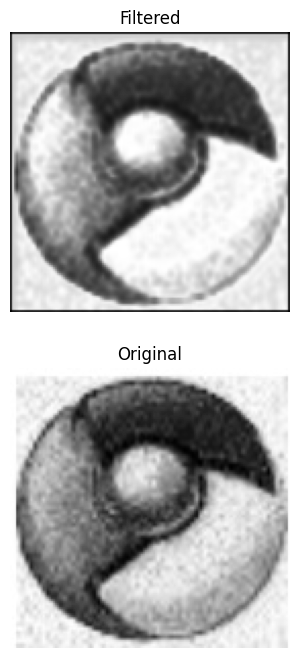

In [66]:
# J(i) = sum_m(W(m, i)I(m))
flattened = g_logo.flatten()
filtered = np.zeros(flattened.shape)

for i in range(flattened.size):
    filtered[i] = np.dot(W[:, i], flattened)

filtered = filtered.reshape(g_logo.shape)

fig = plt.figure(figsize=(4, 8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.axis('off')
ax2.axis('off')
ax1.title.set_text('Filtered')
ax2.title.set_text('Original')
ax1.imshow(filtered, cmap='gray')
ax2.imshow(g_logo, cmap='gray')
plt.show()

# Question 3 : Block Truncation Coding (BTC) (25 points)
BTC is a fast and lossy compression technique. In this problem, we will understand how BTC is
used, along with its advantages and disadvantages. 4x4 blocks are used where applicable in
the following sub-problems. You can use the following link to learn more about BTC:
https://en.wikipedia.org/wiki/Block_Truncation_Coding#Encoder . Helpful functions: col2im,
im2col, bi2de, de2bi.

a) (5 points) You should read ronaldo.jpg, and make it grayscale. Resize the image by a
factor of ½ to make the compression faster. Resize the image further such that the
height and width of the images are both multiples of 4; such that it is still roughly the
same dimensions as ½ of the original image dimensions. Display the grayscale
compressed image.

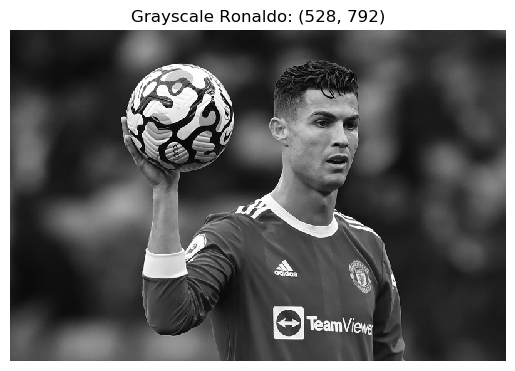

In [125]:
ronaldo = mpimg.imread('images/q3_ronaldo.jpg')
g_ronaldo = 255 * color.rgb2gray(ronaldo)
rows = (g_ronaldo.shape[0] // 4) * 4
cols = (g_ronaldo.shape[1] // 4) * 4
g_ronaldo = cv2.resize(g_ronaldo, (int(cols / 2), int(rows / 2)))

imgplot = plt.imshow(g_ronaldo, cmap='gray')
plt.title('Grayscale Ronaldo: ' + str(g_ronaldo.shape))
plt.axis('off')
plt.show()

b) (5 points) Write a function to compute the mean and standard deviation of a 4x4 block
with ‘B1’ bits to compute and store the mean, and ‘B2’ bits to compute and store the
standard deviation; where ‘B1’ and ‘B2’ are input parameters to the function. Hint: you
might need to compute the mean and standard deviation values, and then truncate in the
end based on ‘B1’ and ‘B2’ parameter values.

In [133]:
def analyze_block(block, B1, B2):
    mean = (np.mean(block) // (2 ** (8 - B1))) * (2 ** (8 - B1))
    stddev = (np.std(block) // (2 ** (8 - B2))) * (2 ** (8 - B2))
    return mean, stddev

c) (5 points) Write a function to compute the 4x4 BTC binary block by thresholding the input
4x4 image block at the mean. Pass ronaldo.jpg through this function for 3 different ‘B1’,
‘B2’ settings; {2,1}, {3,3}, and {7,5}. Compute the BTC binary blocks image for
ronaldo.jpg, and display the 3 images in a 3x1 grid with appropriate labels.

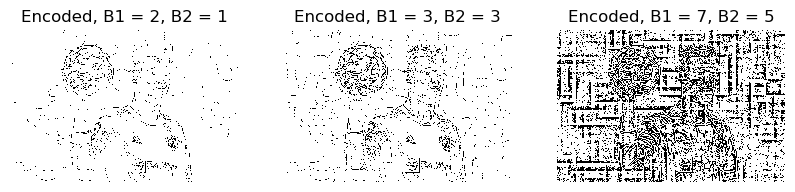

In [139]:
def encode_btc_block(block, mean, stddev):
    coded_block = block.copy()
    coded_block[coded_block < mean] = 0
    coded_block[coded_block >= mean] = 1
    return coded_block

def encode_btc_image(img, B1, B2):
    coded = np.zeros(img.shape)
    rows, cols = img.shape
    means = np.zeros((rows // 4, cols // 4))
    stddevs = np.zeros(means.shape)
    for i in range(rows // 4):
        for j in range(cols // 4):
            block = img[i*4:(i+1)*4, j*4:(j+1)*4]
            means[i, j], stddevs[i, j] = analyze_block(block, B1, B2)
            coded[i*4:(i+1)*4, j*4:(j+1)*4] = encode_btc_block(block, means[i, j], stddevs[i, j])
    return coded, means, stddevs
            
btc_imgs = []
btc_imgs.append(encode_btc_image(g_ronaldo, 2, 1))
btc_imgs.append(encode_btc_image(g_ronaldo, 3, 3))
btc_imgs.append(encode_btc_image(g_ronaldo, 7, 5))

fig = plt.figure(figsize=(10, 2))
ax = []
for i in range(3):
    ax.append(fig.add_subplot(1,3,i+1))
    ax[i].axis('off') 
ax[0].title.set_text('Encoded, B1 = 2, B2 = 1')
ax[1].title.set_text('Encoded, B1 = 3, B2 = 3')
ax[2].title.set_text('Encoded, B1 = 7, B2 = 5')
ax[0].imshow(btc_imgs[0][0], cmap='gray')
ax[1].imshow(btc_imgs[1][0], cmap='gray')
ax[2].imshow(btc_imgs[2][0], cmap='gray')
plt.show()

d) (5 points) Write a function to decode a 4x4 BTC binary block given the mean and
standard deviation as the input parameters, and get back the original 4x4 image block.
Pass the 3 BTC binary block images generated in part c) through this function, for the
aforementioned ‘B1’, ‘B2’ settings; and get back the 3 decompressed ronaldo.jpg
images. Display these three images along with the original image in a 2x2 grid with
appropriate labels.

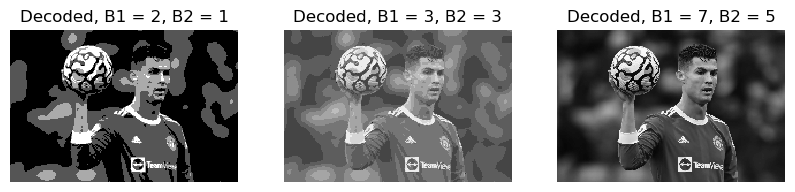

In [152]:
def decode_btc_block(block, mean, stddev):
    Q = np.count_nonzero(block)
    P = 16 - Q
    A = math.sqrt(Q / P) if P != 0 else 1
    decoded_block = block.copy()
    for i in range(block.shape[0]):
        for j in range(block.shape[1]):
            decoded_block[i, j] = mean + stddev / A if block[i, j] == 1 else mean - stddev * A
    return decoded_block

def decode_btc_image(img, means, stddevs):
    decoded = np.zeros(img.shape)
    rows, cols = img.shape
    for i in range(rows // 4):
        for j in range(cols // 4):
            block = img[i*4:(i+1)*4, j*4:(j+1)*4]
            decoded[i*4:(i+1)*4, j*4:(j+1)*4] = decode_btc_block(block, means[i, j], stddevs[i, j])
    return decoded

fig = plt.figure(figsize=(10, 2))
ax = []
for i in range(3):
    ax.append(fig.add_subplot(1,3,i+1))
    ax[i].axis('off') 
ax[0].title.set_text('Decoded, B1 = 2, B2 = 1')
ax[1].title.set_text('Decoded, B1 = 3, B2 = 3')
ax[2].title.set_text('Decoded, B1 = 7, B2 = 5')
ax[0].imshow(decode_btc_image(*btc_imgs[0]), cmap='gray')
ax[1].imshow(decode_btc_image(*btc_imgs[1]), cmap='gray')
ax[2].imshow(decode_btc_image(*btc_imgs[2]), cmap='gray')
plt.show()

e) (5 points) Compute and report the compression ratios for the 3 BTC encoded images
generated.

In [157]:
original_bpp = 8
btc_1_bpp = (16 + 2 + 1) / 16
btc_2_bpp = (16 + 3 + 3) / 16
btc_3_bpp = (16 + 7 + 5) / 16

print(f'Compression Ratio for B1 = 2, B2 = 1 is {round(original_bpp / btc_1_bpp, 3)}:1')
print(f'Compression Ratio for B1 = 3, B2 = 3 is {round(original_bpp / btc_2_bpp, 3)}:1')
print(f'Compression Ratio for B1 = 7, B2 = 5 is {round(original_bpp / btc_3_bpp, 3)}:1')

Compression Ratio for B1 = 2, B2 = 1 is 6.737:1
Compression Ratio for B1 = 3, B2 = 3 is 5.818:1
Compression Ratio for B1 = 7, B2 = 5 is 4.571:1


# Question 4 : Open Ended (5 marks)
Frame a question for me worth 5 marks based on any concept you learnt in Module 4 or 5 (that
hasn’t already been covered in the homeworks). It should be complete with helpful functions,
input images, and a small paragraph on how you would approach the problem (only text, no
code required).

Implement a function that performs average pooling on an input image. The function should take a block size as an input argument that defines how large the tiles are. The function should work with RGB or grayscale images (hint: you can apply the average pooling operation on each channel and then combine back to get the resultant image). Display the input image and the average pooled image side by side.

Helpful Functions: np.mean, np.lib.stride_tricks.sliding_window_view, np.dstack

Input Image:

![q4_tiger.jpg](images/q4_tiger.jpg "q4_tiger.jpg")

Approach: Create a function that average pools a single channel. Using the helpful functions above or manual iteration, this should not be a hard task. Then create a function that splits an input image into its color channels and applies the first function to each channel. Finally that function should return the combined result.